# Ingestion des données météo (France, 2024)

À partir d'un jeu de données téléchargé ici : https://www.ncei.noaa.gov/access/search/data-search/global-summary-of-the-day, filtré sur les données météo pour la France en 2024.

In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import reverse_geocoder as rg

pd.options.display.max_columns = None # affiche toutes les colonnes lors de l'affichage des DataFrames

In [66]:
# variables disponibles : STATION	NAME	LATITUDE	LONGITUDE	ELEVATION	DATE	DEWP	FRSHTT	GUST	MAX	MIN	MXSPD	PRCP	SLP	SNDP	STP	TEMP	VISIB	WDSP

# variables intéressantes : 
# LATITUDE
# LONGITUDE
# ELEVATION : altitude de la station ()
# DATE
# GUST : maximum wind gust (.1 knots) 
# MAX : maximum temperature (.1 Fahrenheit)
# MIN : minimum temperature (.1 Fahrenheit)
# PRCP : precipitation amount (.01 inches)
# SNDP : snow depth (.1 inches)
# FRSHTT : indicator of frost, rain, snow, hail, thunder, tornado (6 characters, each either 0 or 1)
# VISIB : mean visibility (.1 miles)

# récupère les données météo
meteo = pd.read_csv(
    "../data/1-raw/meteo/2024-france-daily.csv",
    usecols = ["DATE", "LATITUDE", "LONGITUDE", "ELEVATION", "GUST", "MAX", "MIN", "PRCP", "SNDP", "VISIB", "FRSHTT"],
    dtype={
        "LATITUDE": float,
        "LONGITUDE": float,
        "ELEVATION": float,
        "FRSHTT": "string",
        "GUST": float,
        "MAX": float,
        "MIN": float,
        "PRCP": float,
        "SNDP": float,
        "VISIB": float},
    parse_dates=['DATE']
)

# suppression des valeurs manquantes codées
meteo = meteo.replace(999.90, np.nan)
meteo = meteo.replace(99.99, np.nan)
meteo = meteo.replace(9999.9, np.nan)

# décompose FRSHTT en colonnes séparées
events = ['frost', 'rain', 'snow', 'hail', 'thunder', 'tornado']
for i, event in enumerate(events):
    meteo[event] = meteo['FRSHTT'].str[i].astype(int).astype(bool)

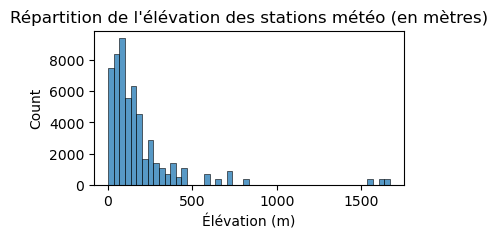

(55666, 17)

In [67]:
# Répartition de l'élévation des stations météo
plt.figure(figsize=(4, 2))
sns.histplot(meteo['ELEVATION'].dropna(), bins=50, kde=False)
plt.title("Répartition de l'élévation des stations météo (en mètres)")
plt.xlabel("Élévation (m)")
plt.show()
meteo.shape


(52307, 17)

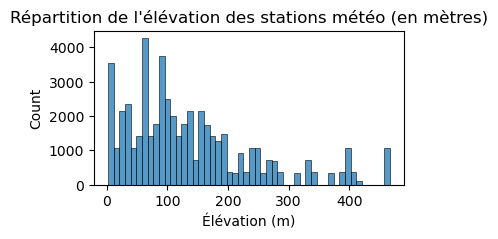

In [68]:
# Afin d'avoir des mesures cohérentes, on enlève les quelques stations d'altitude (au delà de 500m)
meteo = meteo[meteo['ELEVATION'] < 500]

# Répartition de l'élévation des stations météo
plt.figure(figsize=(4, 2))
sns.histplot(meteo['ELEVATION'].dropna(), bins=50, kde=False)
plt.title("Répartition de l'élévation des stations météo (en mètres)")
plt.xlabel("Élévation (m)")
meteo.shape

In [69]:
# fonction : à partir de lat lon, retrouve la région
def get_region(lat, lon):
    coordinates = (lat, lon)
    results = rg.search(coordinates, mode=1)  # mode=1 for single query
    if results:
        return results[0]['admin1']  # returns the region/state name
    return None

In [70]:
# tableau de correspondance entre les régions de reverse_geocoder (en anglais) et les régions françaises actuelles (en français)
traduction_regions = {
    "Alsace": "Grand Est",
    "Aquitaine": "Nouvelle-Aquitaine",
    "Aragon": None,
    "Auvergne": "Auvergne-Rhône-Alpes",
    "Bourgogne": "Bourgogne-Franche-Comté",
    "Brittany": "Bretagne",
    "Centre": "Centre-Val de Loire",
    "Champagne-Ardenne": "Grand Est",
    "Corsica": "Corse",
    "Franche-Comte": "Bourgogne-Franche-Comté",
    "Haute-Normandie": "Normandie",
    "Ile-de-France": "Ile-de-France",
    "Languedoc-Roussillon": "Occitanie",
    "Limousin": "Nouvelle-Aquitaine",
    "Lorraine": "Grand Est",
    "Lower Normandy": "Normandie",
    "Midi-Pyrenees": "Occitanie",
    "Nord-Pas-de-Calais": "Hauts-de-France",
    "Pays de la Loire": "Pays de la Loire",
    "Picardie": "Hauts-de-France",
    "Poitou-Charentes": "Nouvelle-Aquitaine",
    "Provence-Alpes-Cote d'Azur": "Provence-Alpes-Côte d'Azur",
    "Rhone-Alpes": "Auvergne-Rhône-Alpes",
    "Vaud": None
}

# pour éviter de sur-utiliser get_region(), qui est assez lente, on l'utilise uniquement sur les stations uniques
stations = meteo[["LATITUDE", "LONGITUDE"]].drop_duplicates()
for i, row in stations.iterrows():
    region = get_region(row['LATITUDE'], row['LONGITUDE'])
    stations.at[i, 'region_en'] = region

# on traduit tout ça en français avec les régions actuelles
stations['region'] = stations['region_en'].map(traduction_regions)
stations = stations.drop(columns=['region_en'])
stations

,LATITUDE,LONGITUDE,region
0,48.833333,-3.466667,Bretagne
355,47.058056,2.370278,Centre-Val de Loire
710,47.678492,1.208844,Centre-Val de Loire
1064,45.638050,5.880225,Auvergne-Rhône-Alpes
1421,43.606415,5.109250,Provence-Alpes-Côte d'Azur
...,...,...,...
54035,41.924416,9.406000,Corse
54391,49.650106,-1.470281,Normandie
54747,45.220000,5.850000,Auvergne-Rhône-Alpes
54950,48.033333,-0.733333,Pays de la Loire


In [71]:
# puis on merge avec le DataFrame meteo
meteo_copy = meteo.copy()
meteo_copy = meteo_copy.merge(stations, on=["LATITUDE", "LONGITUDE"], how='left')
meteo_copy = meteo_copy.dropna(subset=['region']).copy()

meteo_copy

,LATITUDE,LONGITUDE,ELEVATION,DATE,FRSHTT,GUST,MAX,MIN,PRCP,SNDP,VISIB,frost,rain,snow,hail,thunder,tornado,region
0,48.833333,-3.466667,58.00,2024-01-01,010000,NaN,54.9,45.7,0.24,NaN,7.8,False,True,False,False,False,False,Bretagne
1,48.833333,-3.466667,58.00,2024-01-02,010000,NaN,57.2,51.4,0.79,NaN,5.2,False,True,False,False,False,False,Bretagne
2,48.833333,-3.466667,58.00,2024-01-03,010000,NaN,54.0,48.9,0.20,NaN,7.0,False,True,False,False,False,False,Bretagne
3,48.833333,-3.466667,58.00,2024-01-04,010000,NaN,53.8,46.4,0.12,NaN,9.3,False,True,False,False,False,False,Bretagne
4,48.833333,-3.466667,58.00,2024-01-05,000000,NaN,51.4,45.5,0.20,NaN,NaN,False,False,False,False,False,False,Bretagne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52302,48.636008,4.899417,139.59,2024-12-27,100000,NaN,44.6,26.6,0.00,NaN,5.2,True,False,False,False,False,False,Grand Est
52303,48.636008,4.899417,139.59,2024-12-28,100000,NaN,30.2,24.8,0.00,NaN,0.8,True,False,False,False,False,False,Grand Est
52304,48.636008,4.899417,139.59,2024-12-29,000000,NaN,33.8,30.2,0.00,NaN,5.8,False,False,False,False,False,False,Grand Est
52305,48.636008,4.899417,139.59,2024-12-30,000000,NaN,33.8,30.2,0.00,NaN,6.0,False,False,False,False,False,False,Grand Est


In [72]:
# group by region, date, et calcule les moyennes/max/min des variables météo

# pour rappel :
# GUST : maximum wind gust (.1 knots) 
# MAX : maximum temperature (.1 Fahrenheit)
# MIN : minimum temperature (.1 Fahrenheit)
# PRCP : precipitation amount (.01 inches)
# SNDP : snow depth (.1 inches)
# FRSHTT : indicator of frost, rain, snow, hail, thunder, tornado (6 characters, each either 0 or 1)
# VISIB : mean visibility (.1 miles)
# 'frost', 'rain, 'snow', 'hail', 'thunder', 'tornado' : True / False

meteo_grouped = meteo_copy.groupby(['region', 'DATE']).agg(
    gust_max = ('GUST', 'max'),
    temp_max = ('MAX', 'max'),
    temp_min = ('MIN', 'min'),
    prcp_mean = ('PRCP', 'mean'),
    sndp_mean = ('SNDP', 'mean'),
    visib_mean = ('VISIB', 'mean'),
    frost = ('frost', 'max'),
    rain = ('rain', 'max'),
    snow = ('snow', 'max'),
    hail = ('hail', 'max'),
    thunder = ('thunder', 'max'),
    tornado = ('tornado', 'max')
).reset_index()

meteo_grouped.head(20)

# convertit les données en unités métriques
for col in ['gust_max']:
    meteo_grouped[col] = meteo_grouped[col] * 1.852  # knots to km/h
for col in ['temp_max', 'temp_min']:
    meteo_grouped[col] = (meteo_grouped[col] - 32) * 5.0/9.0  # Fahrenheit to Celsius
for col in ['prcp_mean', 'sndp_mean']:
    meteo_grouped[col] = meteo_grouped[col] * 25.4  # inches to mm
for col in ['visib_mean']:
    meteo_grouped[col] = meteo_grouped[col] * 1.60934  # miles to kilometers

meteo_grouped

,region,DATE,gust_max,temp_max,temp_min,prcp_mean,sndp_mean,visib_mean,frost,rain,snow,hail,thunder,tornado
0,Auvergne-Rhône-Alpes,2024-01-01,NaN,11.388889,-0.500000,7.170615,13.546667,12.016405,True,True,False,False,False,False
1,Auvergne-Rhône-Alpes,2024-01-02,66.4868,14.222222,-0.500000,1.074615,10.160000,12.271218,True,True,False,False,False,False
2,Auvergne-Rhône-Alpes,2024-01-03,98.1560,16.111111,1.000000,5.568462,10.160000,12.633319,True,True,False,False,False,False
3,Auvergne-Rhône-Alpes,2024-01-04,50.0040,15.111111,0.888889,0.296333,NaN,12.834487,True,True,False,False,False,False
4,Auvergne-Rhône-Alpes,2024-01-05,NaN,11.277778,3.000000,1.676400,10.160000,11.359258,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4672,Provence-Alpes-Côte d'Azur,2024-12-27,NaN,18.611111,-6.611111,0.000000,NaN,11.353162,False,False,False,False,False,False
4673,Provence-Alpes-Côte d'Azur,2024-12-28,NaN,18.888889,-6.000000,0.023091,NaN,11.221489,False,False,False,False,False,False
4674,Provence-Alpes-Côte d'Azur,2024-12-29,NaN,17.500000,-5.777778,0.000000,NaN,11.909116,False,False,False,False,False,False
4675,Provence-Alpes-Côte d'Azur,2024-12-30,NaN,16.000000,-5.777778,0.023091,NaN,10.299776,True,False,False,False,False,False


# Vérifications de cohérence des données

<Axes: title={'center': 'Distribution de la vitesse maximale des rafales de vent (km/h)'}, ylabel='Frequency'>

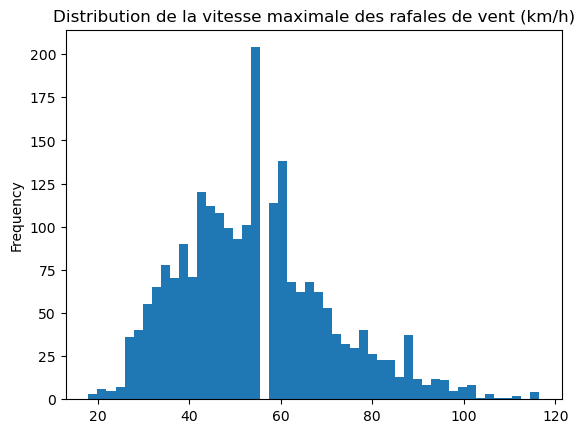

In [73]:
df = meteo_grouped.copy()

df['gust_max'].plot(kind='hist', bins=50, title='Distribution de la vitesse maximale des rafales de vent (km/h)')

<Axes: title={'center': 'Distribution de la température maximale (°C)'}, ylabel='Frequency'>

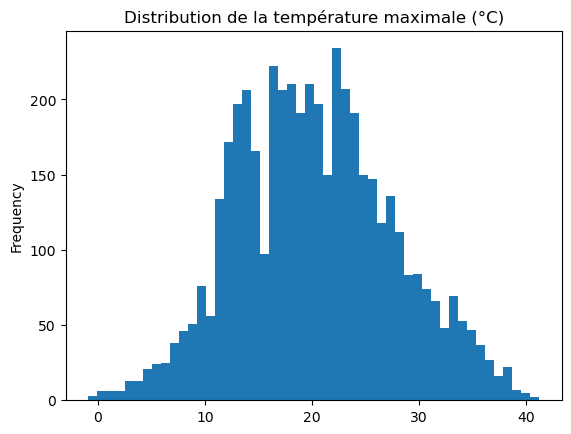

In [74]:
df['temp_max'].plot(kind='hist', bins=50, title='Distribution de la température maximale (°C)')

<Axes: title={'center': 'Distribution de la température minimale (°C)'}, ylabel='Frequency'>

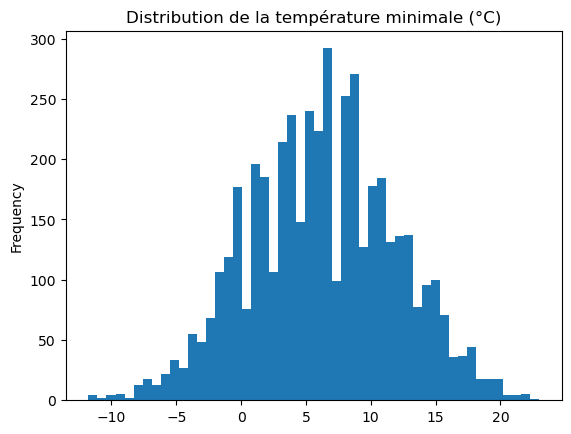

In [75]:
df['temp_min'].plot(kind='hist', bins=50, title='Distribution de la température minimale (°C)')

<Axes: title={'center': 'Distribution de la précipitation moyenne (mm)'}, ylabel='Frequency'>

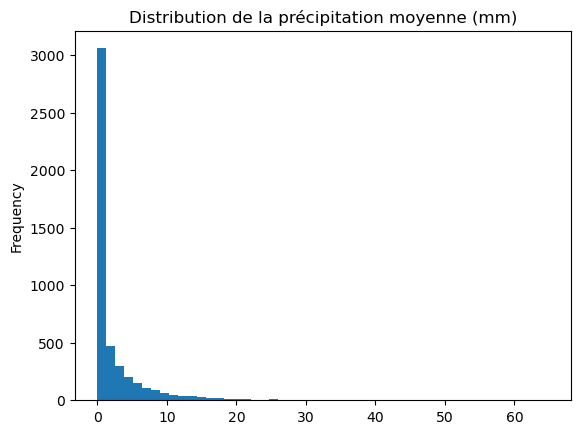

In [76]:
df['prcp_mean'].plot(kind='hist', bins=50, title='Distribution de la précipitation moyenne (mm)')

<Axes: title={'center': 'Distribution de la visibilité moyenne (km)'}, ylabel='Frequency'>

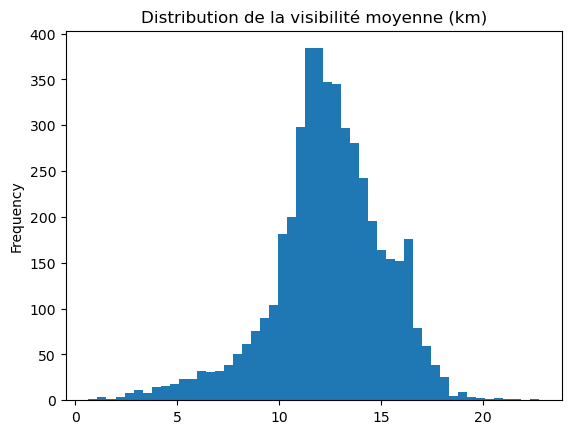

In [77]:
df['visib_mean'].plot(kind='hist', bins=50, title='Distribution de la visibilité moyenne (km)')

<Axes: title={'center': 'Distribution de la hauteur de neige (cm)'}, ylabel='Frequency'>

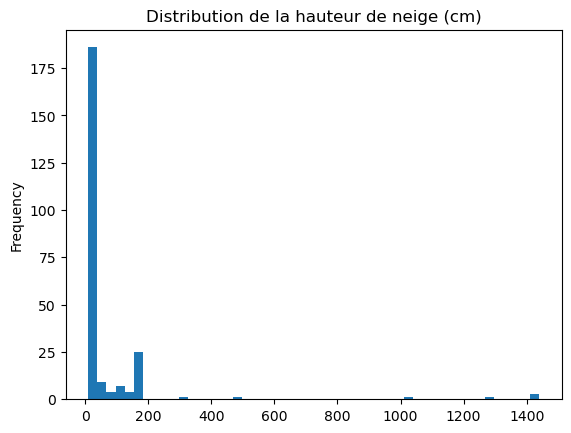

In [79]:
df['sndp_mean'].plot(kind='hist', bins=50, title='Distribution de la hauteur de neige (cm)')

# Sauvegarde en Parquet

In [78]:
meteo_grouped.to_parquet("../data/2-clean/meteo/meteo_france_2024.parquet", index=False)